In [10]:
# Imports
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
from web3 import Web3
from datetime import datetime, timedelta, timezone

# Connect to ETH blockchain with infura API key
w3 = Web3(Web3.HTTPProvider('https://mainnet.infura.io/v3/5f0c4998d7544ee1bb3f0dc297a6821c'))

In [2]:
# Align to nearest previous interval
def align_to_interval(dt, interval_hours):
    aligned_hour = (dt.hour // interval_hours) * interval_hours
    return dt.replace(hour=aligned_hour, minute=0, second=0, microsecond=0, tzinfo=timezone.utc)

# Find block number closest to timestamp with binary search
def get_block_number_by_timestamp(target_timestamp):
    low, high = 0, w3.eth.block_number
    while low < high:
        mid = (low + high) // 2
        mid_block_timestamp = w3.eth.get_block(mid).timestamp
        if mid_block_timestamp < target_timestamp:
            low = mid+1
        else:
            high = mid
    return low

# Interpolate block number of target time between start and end blocks to minimize api calls
def interpolate_block_numbers(start_block, end_block, start_time, end_time, target_time):
    block_interval = end_block - start_block
    time_interval = (end_time - start_time).total_seconds()
    time_offset = (target_time - start_time).total_seconds()
    
    # Find interpolated block number for target time
    interpolated_block = start_block + (block_interval * (time_offset / time_interval))
    return int(interpolated_block)

# Get block numbers for specified timeframe and timestep
def get_blocks_for_timeframe(interval_hours, days_back):
    block_numbers = {}
    end_datetime = datetime.utcnow()
    start_datetime = end_datetime - timedelta(days = days_back)
    
    # Align start and end times to nearest previous interval
    start_datetime = align_to_interval(start_datetime, interval_hours)
    end_datetime = align_to_interval(end_datetime, interval_hours)
    
    # Get block numbers for start and end (2 api calls)
    start_block = get_block_number_by_timestamp(int(start_datetime.timestamp()))
    end_block = get_block_number_by_timestamp(int(end_datetime.timestamp()))
    
    # Loop from start datetime to end datetime and store block numbers for intervals
    current_datetime = start_datetime
    while current_datetime <= end_datetime:
        target_timestamp = int(current_datetime.timestamp())
        
        if current_datetime == start_datetime:
            block_number = start_block
        elif current_datetime == end_datetime:
            block_number = end_block
        else:
            # Find interpolated block number
            block_number = interpolate_block_numbers(start_block,
                                                     end_block,
                                                     start_datetime,
                                                     end_datetime,
                                                     current_datetime)
        
        formatted_key = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
        block_numbers[formatted_key] = block_number        
        current_datetime += timedelta(hours=interval_hours)
        
    return block_numbers

In [4]:
# Reserve data object
class ReserveData:
    def __init__(self, data):
        self.unbacked_aTokens = data[0]
        self.tokens_accrued_to_treasury = data[1]
        self.total_aToken_supply = data[2]
        self.total_stable_debt = data[3]
        self.total_variable_debt = data[4]
        self.liquidity_rate = data[5]
        self.variable_borrow_rate = data[6]
        self.stable_borrow_rate = data[7]
        self.average_stable_borrow_rate = data[8]
        self.liquidity_index = data[9]
        self.variable_borrow_index = data[10]
        self.last_update_timestamp = data[11]

    def __repr__(self):
        return (f"ReserveData(\n\tunbacked_aTokens = {self.unbacked_aTokens}, "
                f"\n\ttokens_accrued_to_treasury = {self.tokens_accrued_to_treasury}, "
                f"\n\ttotal_aToken_supply = {self.total_aToken_supply}, "
                f"\n\ttotal_stable_debt = {self.total_stable_debt}, "
                f"\n\ttotal_variable_debt = {self.total_variable_debt}, "
                f"\n\tliquidity_rate = {self.liquidity_rate}, "
                f"\n\tvariable_borrow_rate = {self.variable_borrow_rate}, "
                f"\n\tstable_borrow_rate = {self.stable_borrow_rate}, "
                f"\n\taverage_stable_borrow_rate = {self.average_stable_borrow_rate}, "
                f"\n\tliquidity_index = {self.liquidity_index}, "
                f"\n\tvariable_borrow_index = {self.variable_borrow_index}, "
                f"\n\tlast_update_timestamp = {self.last_update_timestamp}\n)")

# Historical borrow function
def historical_borrow_and_supply(market = 'AAVE', timeframe = 365, interval = 6, token = 'rETH'):
    """
    Fetches historical borrow and supply totals for a specified token from the specified protocol over a given timeframe and at specified intervals.
    
    Parameters:
    - markets (str): The lending and borrowing market from which to fetch data. Defaults to 'AAVE'.
    - timeframe (int): The number of days back from the current date to fetch data. Defaults to 365 days.
    - interval (int): The interval, in hours, at which to fetch data. Defaults to 1 hour.
    - token (str): The name of the token to fetch data for. Defaults to 'rETH'.
    
    Returns:
    pandas.DataFrame: A DataFrame where each row corresponds to a time point within the timeframe and includes the following columns:
        - 'Timestamp': The timestamp in 'YYYY-MM-DD HH:MM:SS' format.
        - 'Total Supplied': The total supply amount of the specified token at that time.
        - 'debt_total': The total borrow amount of the specified token at that time.
    
    """
    
    # Map token names to contract addresses
    token_address_map = {
        'rETH': '0xae78736Cd615f374D3085123A210448E74Fc6393'
        # fill with rest
    }
    
    # Map market name to pool contract address and abi filepath
    contract_address_abi_map = {
        'AAVE': ('0x7B4EB56E7CD4b454BA8ff71E4518426369a138a3', './data_provider_abi.json')
        # fill with rest
    }
    
    # Lookup token address, contract address, and abi filepath
    token_address = token_address_map[token]
    contract_address, abi_filepath = contract_address_abi_map[market]
    
    
    # Web3 setup
    with open(abi_filepath) as f:
        abi = json.load(f)

    smart_contract = w3.eth.contract(address=contract_address, abi=abi)
    
    # Get blocks for specified timeframe and interval
    blocks = get_blocks_for_timeframe(interval, timeframe)
    
    # Get borrow and supply amounts
    data = {
        'Timestamp': [],
        'Total Supplied': [],
        'Total Borrowed': [],
    }
    
    for timestamp, block_number in blocks.items():
        reserve_data_result = smart_contract.functions.getReserveData(token_address).call(block_identifier = block_number)
        reserve_data = ReserveData(reserve_data_result)
        
        # Pull out borrowed and supplied totals
        supplied_total = (reserve_data.total_aToken_supply) / 10**18
        borrowed_total = (reserve_data.total_stable_debt + reserve_data.total_variable_debt) / 10**18
        
        # place in dict
        data['Timestamp'].append(timestamp)
        data['Total Supplied'].append(supplied_total)
        data['Total Borrowed'].append(borrowed_total)
        
    return pd.DataFrame(data)



historical_aave_totals = historical_borrow_and_supply()
historical_aave_totals

,Timestamp,Total Supplied,Total Borrowed
0,2023-02-17 18:00:00,174.823432,0.600003
1,2023-02-18 00:00:00,193.849674,0.600127
2,2023-02-18 06:00:00,196.603332,0.600127
3,2023-02-18 12:00:00,196.604333,0.600127
4,2023-02-18 18:00:00,196.604333,0.600127
...,...,...,...
1456,2024-02-16 18:00:00,45067.565062,453.188286
1457,2024-02-17 00:00:00,45065.211643,453.488769
1458,2024-02-17 06:00:00,45067.173511,453.489256
1459,2024-02-17 12:00:00,45067.173925,453.489743


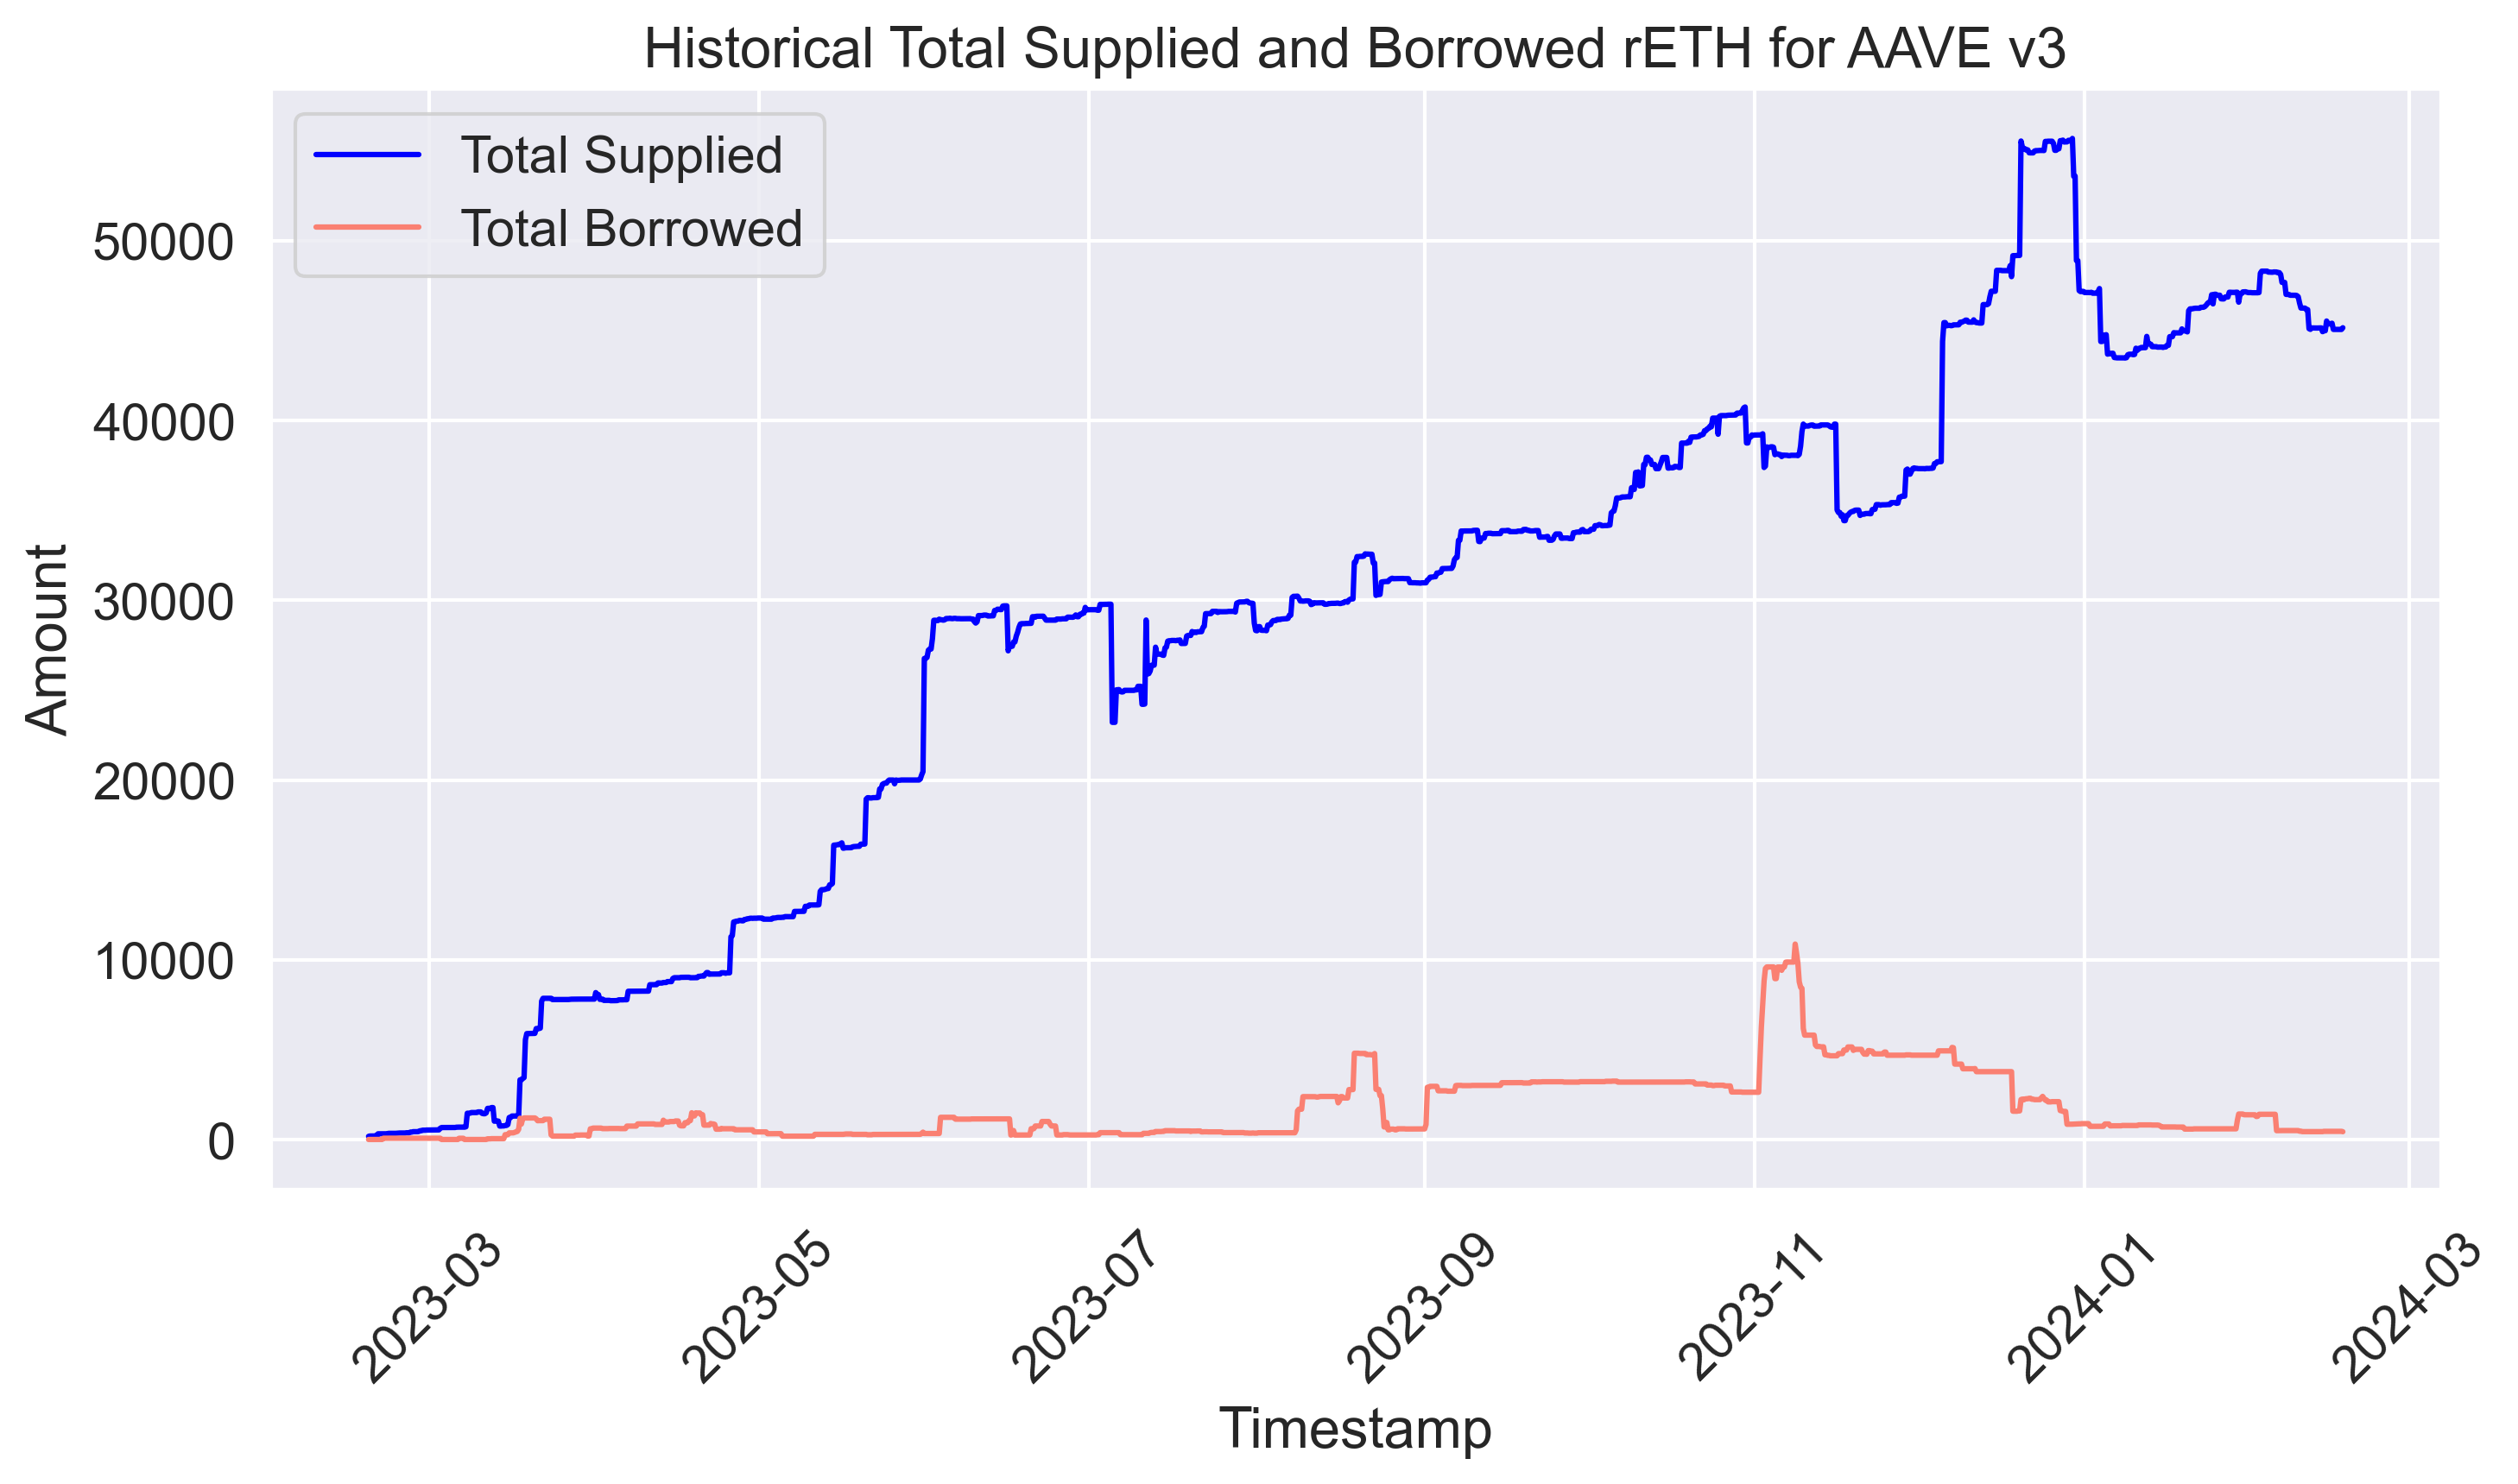

In [20]:
df = historical_aave_totals.copy()
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.sort_values('Timestamp', inplace=True)

# Plot
sns.set_theme(style = 'darkgrid')
sns.set_context("notebook", font_scale=1.3)
plt.figure(figsize=(10,6), dpi=300)
sns.lineplot(data=df, x='Timestamp', y='Total Supplied', linestyle='-', color='blue', label='Total Supplied')
sns.lineplot(data=df, x='Timestamp', y='Total Borrowed', linestyle='-', color='salmon', label='Total Borrowed')

plt.xticks(rotation=45)
plt.xlabel('Timestamp')
plt.ylabel('Amount')
plt.title('Historical Total Supplied and Borrowed rETH for AAVE v3')
plt.legend()
plt.tight_layout()

plt.show()